In [1]:
# import necessary libraries
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from examples.tensorflow_examples.models.pix2pix import pix2pix
import os
from os import listdir
from numpy import asarray
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.layers import Layer, InputSpec
print(tf.__version__)

2.6.2


In [2]:
BATCH_SIZE = 1
BUFFER_SIZE = 1000
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [3]:
# define pre-processing train and test functions
def load_images(path, size=(IMG_WIDTH,IMG_HEIGHT)):
    data_list = list()
    
    for filename in listdir(path):     
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store the data
        data_list.append(pixels)
    return asarray(data_list)
  
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image):
    image = normalize(image)
    return image

In [4]:
# set the train and test input directories
data_dir_ct_train = "/home/kshah/Data/cycleGAN-2D-final/CT-Train/"
data_dir_cbct_train = "/home/kshah/Data/cycleGAN-2D-final/CBCT-Train/"
data_dir_ct_test = "/home/kshah/Data/cycleGAN-2D-final/CT-Test/"
data_dir_cbct_test = "/home/kshah/Data/cycleGAN-2D-final/CBCT-Test/"

In [5]:
# select GPU[1] as the physical device
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')

In [6]:
# load input images, convert into grayscale and store as tensorflow Dataset
ct_data_train = load_images(data_dir_ct_train)
ct_data_train = tf.image.rgb_to_grayscale(ct_data_train) #convert to grayscale
ct_train = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(ct_data_train))

cbct_data_train = load_images(data_dir_cbct_train)
cbct_data_train = tf.image.rgb_to_grayscale(cbct_data_train) #convert to grayscale
cbct_train = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(cbct_data_train))

ct_data_test = load_images(data_dir_ct_test)
ct_data_test = tf.image.rgb_to_grayscale(ct_data_test) #convert to grayscale
ct_test = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(ct_data_test))

cbct_data_test = load_images(data_dir_cbct_test)
cbct_data_test = tf.image.rgb_to_grayscale(cbct_data_test) #convert to grayscale
cbct_test = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(cbct_data_test))

In [7]:
len(list(ct_train))

3753

In [8]:
# apply pre-processing functions and shuffle the input data
AUTOTUNE = tf.data.experimental.AUTOTUNE
ct_train = ct_train.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
cbct_train = cbct_train.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
ct_test = ct_test.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
cbct_test = cbct_test.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
# get a sample image from each category
sample_ct_train = next(iter(ct_train))
sample_cbct_train = next(iter(cbct_train))
sample_ct_test = next(iter(ct_test))
sample_cbct_test = next(iter(cbct_test))

In [10]:
print(tf.shape(sample_cbct_test))

tf.Tensor([  1 256 256   1], shape=(4,), dtype=int32)


In [11]:
# define the generator and discriminator networks
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def unet_generator():
   
    down_stack = [
      downsample(64, 4, apply_norm=False), 
      downsample(128, 4), 
      downsample(256, 4),
      downsample(512, 4),  
      downsample(512, 4), 
      downsample(512, 4),  
      downsample(512, 4),  
      downsample(1024, 4),  
    ]
                  #create a stack of downsample models
    up_stack = [
      upsample(1024, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4), 
      upsample(256, 4),  
      upsample(128, 4),  
      upsample(64, 4),  
               ] #create a stack of upsample models
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') 
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') 
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

generator_g = unet_generator() #initialise the generator
generator_f = unet_generator() #initialise the generator

def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4,  False)(x)  
    down2 = downsample(128, 4)(down1)    
    down3 = downsample(256, 4)(down2)     
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) 
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) 
  
    return tf.keras.Model(inputs=inp, outputs=last) #create the model using input & output layer

discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

tf.Tensor([ 1 30 30  1], shape=(4,), dtype=int32)


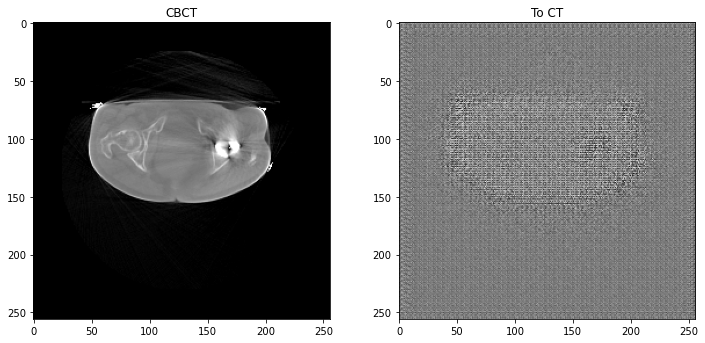

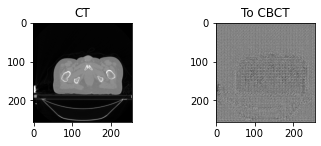

In [12]:
to_ct = generator_g(sample_cbct_train)
to_cbct = generator_f(sample_ct_train)

out = discriminator_x(to_ct)
print(tf.shape(out))
plt.figure(figsize=(12, 12))
contrast = 8

imgs = [sample_cbct_train, to_ct, sample_ct_train, to_cbct]
title = ['CBCT', 'To CT', 'CT', 'To CBCT']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5, cmap='gray')
        plt.show()

In [13]:
LAMBDA = 100
# Using Binarycross entropy with logits true
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
# define the loss functions
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real) #write your code here
    generated_loss = loss_obj(tf.zeros_like(generated), generated) #write your code here
    total_disc_loss = real_loss + generated_loss #write your code here
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) #write your code here
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

#Define the optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [15]:
EPOCHS = 30

checkpoint_path = './checkpoints-split-correct7'  
ckpt = tf.train.Checkpoint(step=tf.Variable(1),
                           generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

def generate_images(model, test_input, epoch):
    prediction = model(test_input)
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    fig, ax = plt.subplot_mosaic([['input', 'prediction']], figsize=(12,12))

    ax['input'].imshow(display_list[0].numpy()[:,:,0] * 0.5 + 0.5, cmap='gray')
    ax['input'].axis('off')
    ax['input'].set_title(title[0])
  
    ax['prediction'].imshow(display_list[1].numpy()[:,:,0] * 0.5 + 0.5, cmap='gray')
    ax['prediction'].axis('off')
    ax['prediction'].set_title(title[1])

    plt.savefig('./results-split-correct3/%s.png'%(epoch))


def generate_images_test(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image', 'Expected Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i].numpy()[:,:,0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.show()

# setting up logs
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

Latest checkpoint restored!!


In [16]:
@tf.function
def train_step(real_x, real_y,epoch):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)  
        cycled_x = generator_f(fake_y, training=True) 
        
        fake_x =  generator_f(real_y, training=True) 
        cycled_y = generator_g(fake_x, training=True) 
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True) 
        same_y = generator_g(real_y, training=True) 
        
        disc_real_x =  discriminator_x(real_x, training=True) 
        disc_real_y = discriminator_y(real_y, training=True) 
        
        disc_fake_x = discriminator_x(fake_x, training=True) 
        disc_fake_y = discriminator_y(fake_y, training=True) 
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
 # calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables) 
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables) 
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables) 
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    with train_summary_writer.as_default():
        tf.summary.scalar('gen_g_total_loss', total_gen_g_loss, step=epoch)
        tf.summary.scalar('gen_g_gan_loss', gen_g_loss, step=epoch)
        tf.summary.scalar('disc_x_loss', disc_x_loss, step=epoch)
        tf.summary.scalar('gen_f_total_loss', total_gen_f_loss, step=epoch)
        tf.summary.scalar('gen_f_gan_loss', gen_f_loss, step=epoch)
        tf.summary.scalar('disc_y_loss', disc_y_loss, step=epoch)
        tf.summary.scalar('cycle_loss', total_cycle_loss, step=epoch)


In [ ]:
# training loop
for epoch in range(EPOCHS):
    print(epoch)
    epoch = tf.convert_to_tensor(epoch+8, dtype=tf.int64)
    for image_x, image_y in tf.data.Dataset.zip((cbct_train, ct_train)): #zebras=ct; horses=cbct;
        ckpt.step.assign_add(1)
        train_step(image_x, image_y, epoch)
    save_path = ckpt_manager.save()
    print("Saved checkpoint for step {}: {}".format(int(epoch), save_path))
    epoch = epoch.numpy()
    generate_images_test(generator_g, sample_cbct_train)
    for inp in ct_test.take(2):
        generate_images_test(generator_f, inp)
    for inp in cbct_test.take(5):
        generate_images_test(generator_g, inp)

In [17]:
checkpoint_path = './checkpoints-split-correct8/'  
ckpt = tf.train.Checkpoint(step=tf.Variable(1),
                           generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


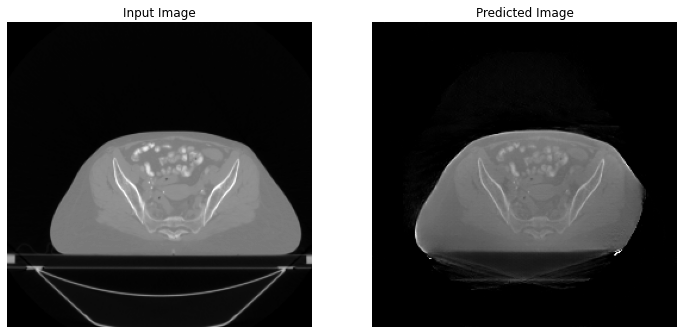

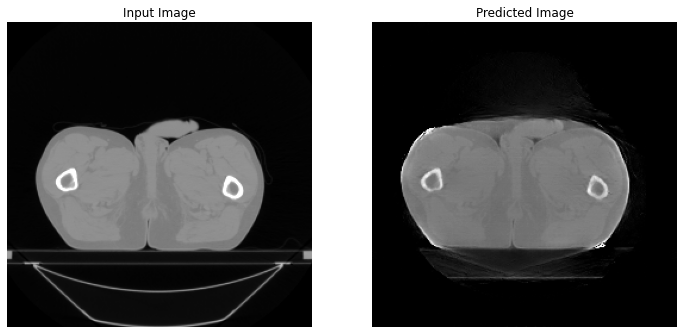

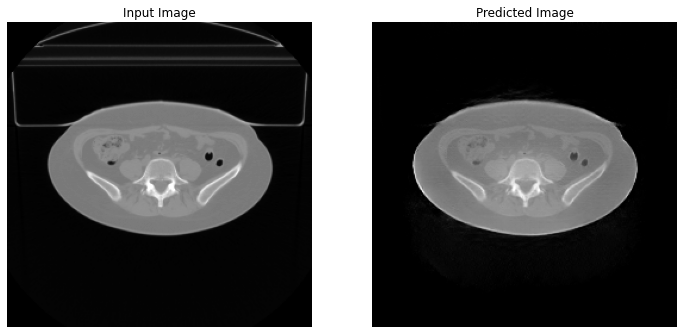

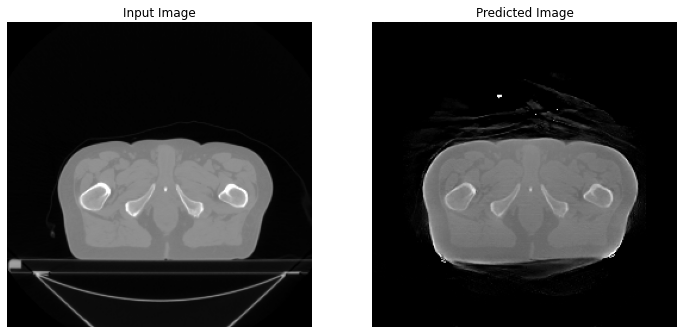

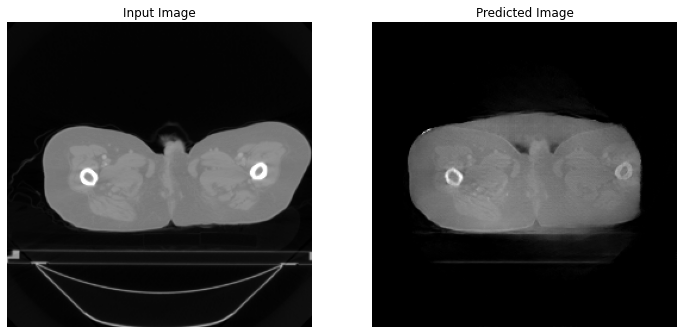

In [18]:
for inp in ct_test.take(5):
    generate_images_test(generator_f, inp)

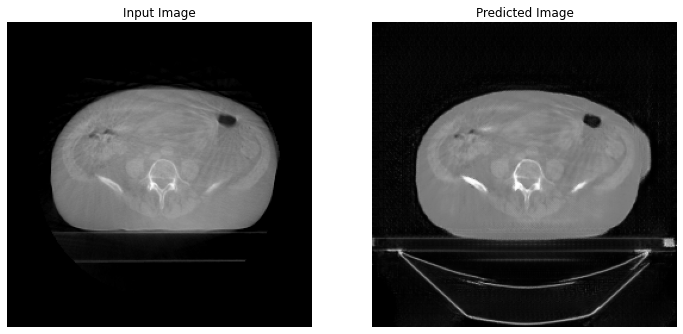

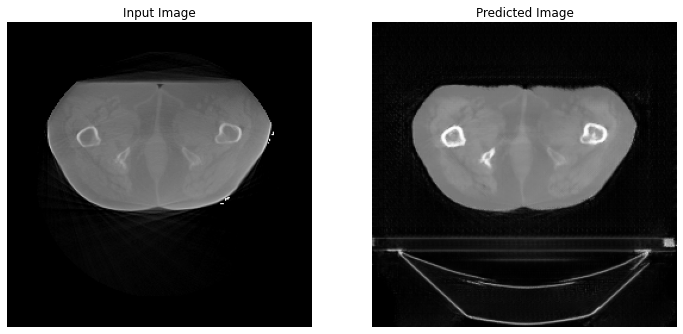

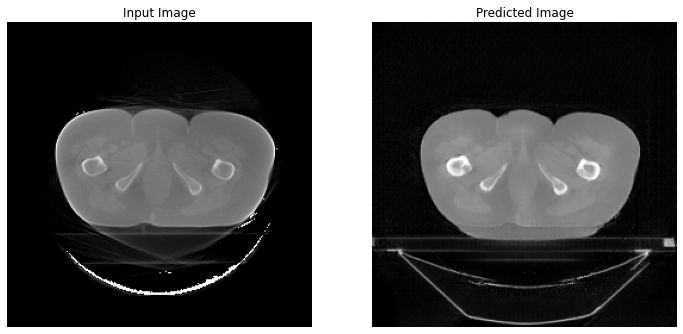

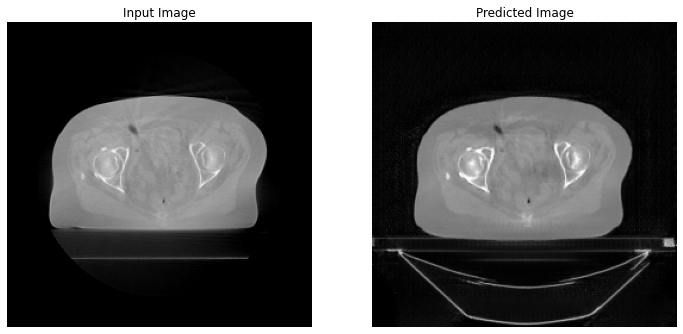

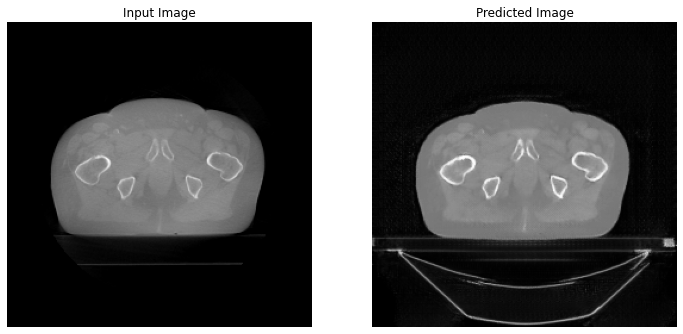

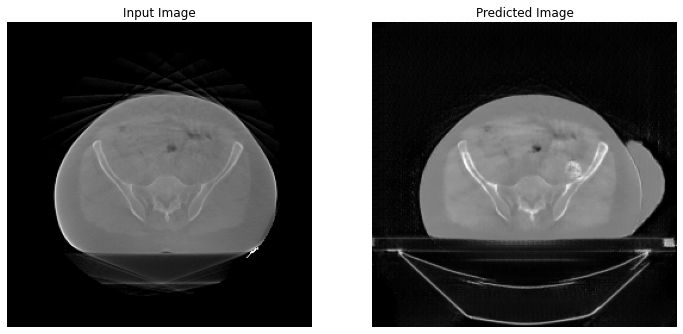

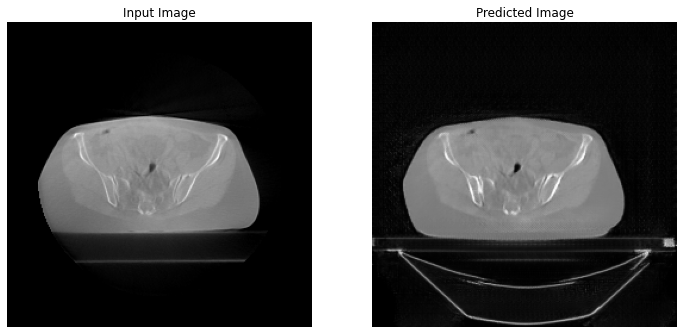

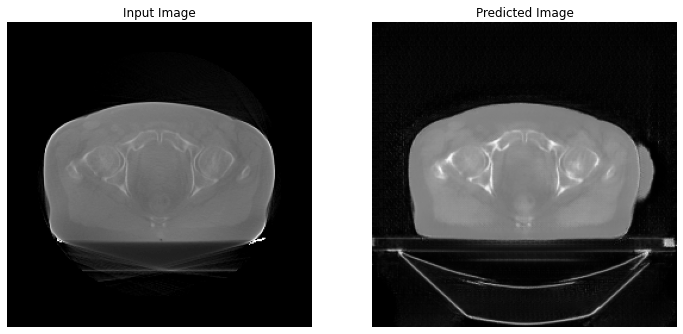

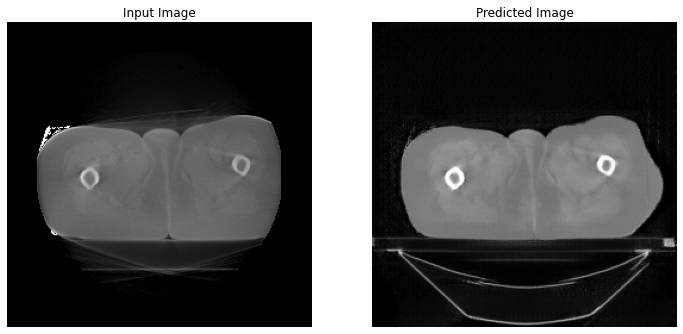

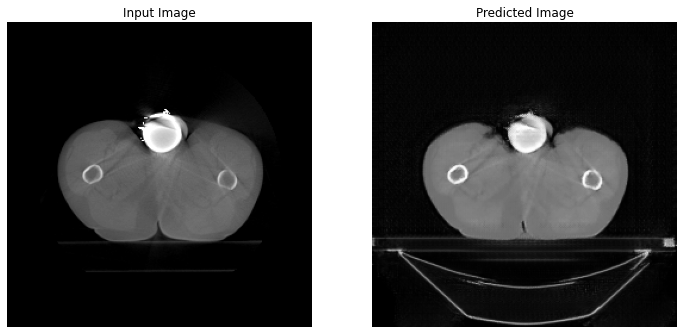

In [19]:
for inp in cbct_test.take(10):
    generate_images_test(generator_g, inp)

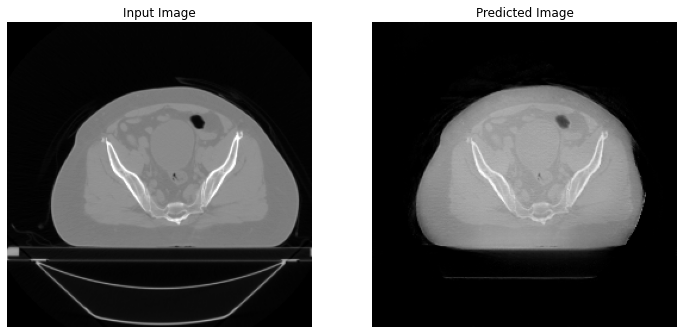

In [20]:
inputdir = '/home/kshah/Data/UNET/Test/CT_img/'
test_list = [ f for f in  os.listdir(inputdir)]
for f in test_list:
    pixels = load_img(inputdir + f, target_size=(256,256))
    # convert to numpy array
    ct_data_test = img_to_array(pixels)
    #print(np.shape(ct_data_test))
    ct_data_test = tf.image.rgb_to_grayscale(ct_data_test) #convert to grayscale
    #print(tf.shape(ct_data_test))
    ct_data_test = preprocess_image_test(ct_data_test)
    ct_data_test = tf.expand_dims(ct_data_test, axis=0)
    #print(tf.shape(ct_data_test))
    generate_images_test(generator_f, ct_data_test)
    break

In [ ]:
# convert and store the test images as dicom files for 3D segmentation
slope = 1
intercept = -512 #For PR-Data (MGH-1)
l = [1,2,7,9,10,12,16,18,20]
for i in l:
    
    pnum = f'{(i):03d}'
    inputdir = '/home/kshah/Data/PR-data/GCS^PR_P%s/cbct0/' %pnum
    outdir = '/home/kshah/Data/Pelvic-Ref-Data/sct/%s/' %pnum
    os.mkdir(outdir)
    test_list = [ f for f in  os.listdir(inputdir)]
    test_list = sorted(test_list)

    for f in test_list: 
        ds = pydicom.read_file(inputdir + f) # read dicom image
        img = ds.pixel_array
        img[img>1900]=1900 # set maximum intensity of each pixel to 1900
        img = cv2.resize(img, dsize=(256,256))
        #print(img.shape())
        scaled_img = (np.maximum(img,0) / img.max()) * 255.0
        cbct_data_test = preprocess_image_test(scaled_img)
        cbct_data_test = tf.expand_dims(cbct_data_test, axis=0)
        prediction = generator_g(cbct_data_test)
        prediction = ((prediction[0].numpy()[:,:,0]) * img.max())
        #prediction = ((prediction[0].numpy()[:,:,0]) + 1.0)/2.0
        #prediction = prediction * img.max()
        prediction = (prediction - intercept)/slope
        prediction = prediction.astype(np.int16)
        prediction = cv2.resize(prediction, dsize=(410,410))
        #print(prediction.shape())
        #ds.Rows = 512
        #ds.Columns = 512
        ds.SeriesDescription = 'NewCBCT-1'
        ds.PixelData = prediction.tobytes()
        ds.save_as(outdir + f)               